# Data and Feature Engineering
---
Guidelines
* Using the same ADULT dataset, recreate the Utilizing the Expert Knowledge
* Hint: The changes should start in [58].

In [41]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from typing import Union, Type
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
%config InlineBackend.figure_format = "retina"
%matplotlib inline

In [42]:
color_a1 = '#664c85'
color_a2 = '#5b92b6'
color_a3 = '#52d5bd'
color_a4 = '#eeeeee'
palette_a1 = 'mako'
palette_a2 = 'mako_r'

## Initialization

### Loading the dataset directly from the repository of mglearn itself

The file has no headers naming the columns so we pass header = None and provide the column names explicitly

In [43]:
df_adult_income = pd.read_csv(
    filepath_or_buffer = 'https://raw.githubusercontent.com/amueller/introduction_to_ml_with_python/master/data/adult.data',
    index_col = False, header = None,
    names = [
        'age', 'workclass', 'fnlwgt', 'education', 
        'education-num','marital-status', 'occupation', 'relationship', 
        'race', 'gender', 'capital-gain', 'capital-loss', 
        'hours-per-week', 'native-country', 'income'])

df_adult_income.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


As the target is `categorical` and `only of two kinds`, I will be treating this as a `classification problem`. Specifically, a `binary classification`.

### Dataset information

In [44]:
df_adult_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   gender          32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [45]:
df_adult_income.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [46]:
df_adult_income.shape

(32561, 15)

### Dataframe preprocessing

Getting the continuous and categorical columns

In [47]:
columns_df_adult_income_categorical =  [column for column in df_adult_income.select_dtypes(include = ['object']).columns]
columns_df_adult_income_numerical = [x for x in df_adult_income.columns if x not in columns_df_adult_income_categorical]

print(f'Categorical columns: {columns_df_adult_income_categorical}')
print(f'Numerical columns: {columns_df_adult_income_numerical}')

Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
Numerical columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


Converting the values in the categorical and numerical columns to its proper data type

In [48]:
df_adult_income[columns_df_adult_income_categorical] = df_adult_income[columns_df_adult_income_categorical].astype('category')
df_adult_income[columns_df_adult_income_numerical] = df_adult_income[columns_df_adult_income_numerical].astype('int64')

Mapping the encoding of target values

In [49]:
encoded_target_values = {
    df_adult_income['income'].unique()[0]: 0,
    df_adult_income['income'].unique()[1]: 1,}

encoded_target_values

{' <=50K': 0, ' >50K': 1}

In [50]:
df_adult_income.dtypes

age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status    category
occupation        category
relationship      category
race              category
gender            category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
income            category
dtype: object

### Feature distribution overview

In [51]:
def plot_pairplot(
    data, hue:str, vars: list[str], 
    title: str = None, palette = None,
) -> sns.pairplot:

    palette = palette_a1 if palette is None else palette
    title = ' ' if title is None else title

    sns.set(style = 'whitegrid')

    g = sns.pairplot(
        data = data, hue = hue, palette = palette,
        vars = vars, diag_kind = 'kde')

    g.fig.suptitle(
        t = "".join([(' '), ('\n'*3), (title)]).upper(), y = 1.11, x = 0.02,
        horizontalalignment = 'left', fontsize = 20, fontweight = 'bold')

    for axes in g.axes:
        axes[0].set_ylabel(
            ylabel = "".join([('\n'*4), (axes[0].get_ylabel()), ('\n')]),
            fontdict = dict(fontsize = 13.5, fontweight = 'medium'))

    for axes in g.axes[len(g.axes)-1]:
        axes.set_xlabel(
            xlabel = "".join([('\n'), (axes.get_xlabel()), ('\n'*4)]),
            fontdict = dict(fontsize = 13.5, fontweight = 'medium'))    

    sns.move_legend(
        obj = g, loc = 'lower left', bbox_to_anchor = (0.01, 1), 
        ncol = 3, title = None, frameon = False,
        markerscale = 2,)

    plt.text(
        s = ' ', x = 1.3, y = 1,
        transform = g.axes[0, -1].transAxes)

    return g

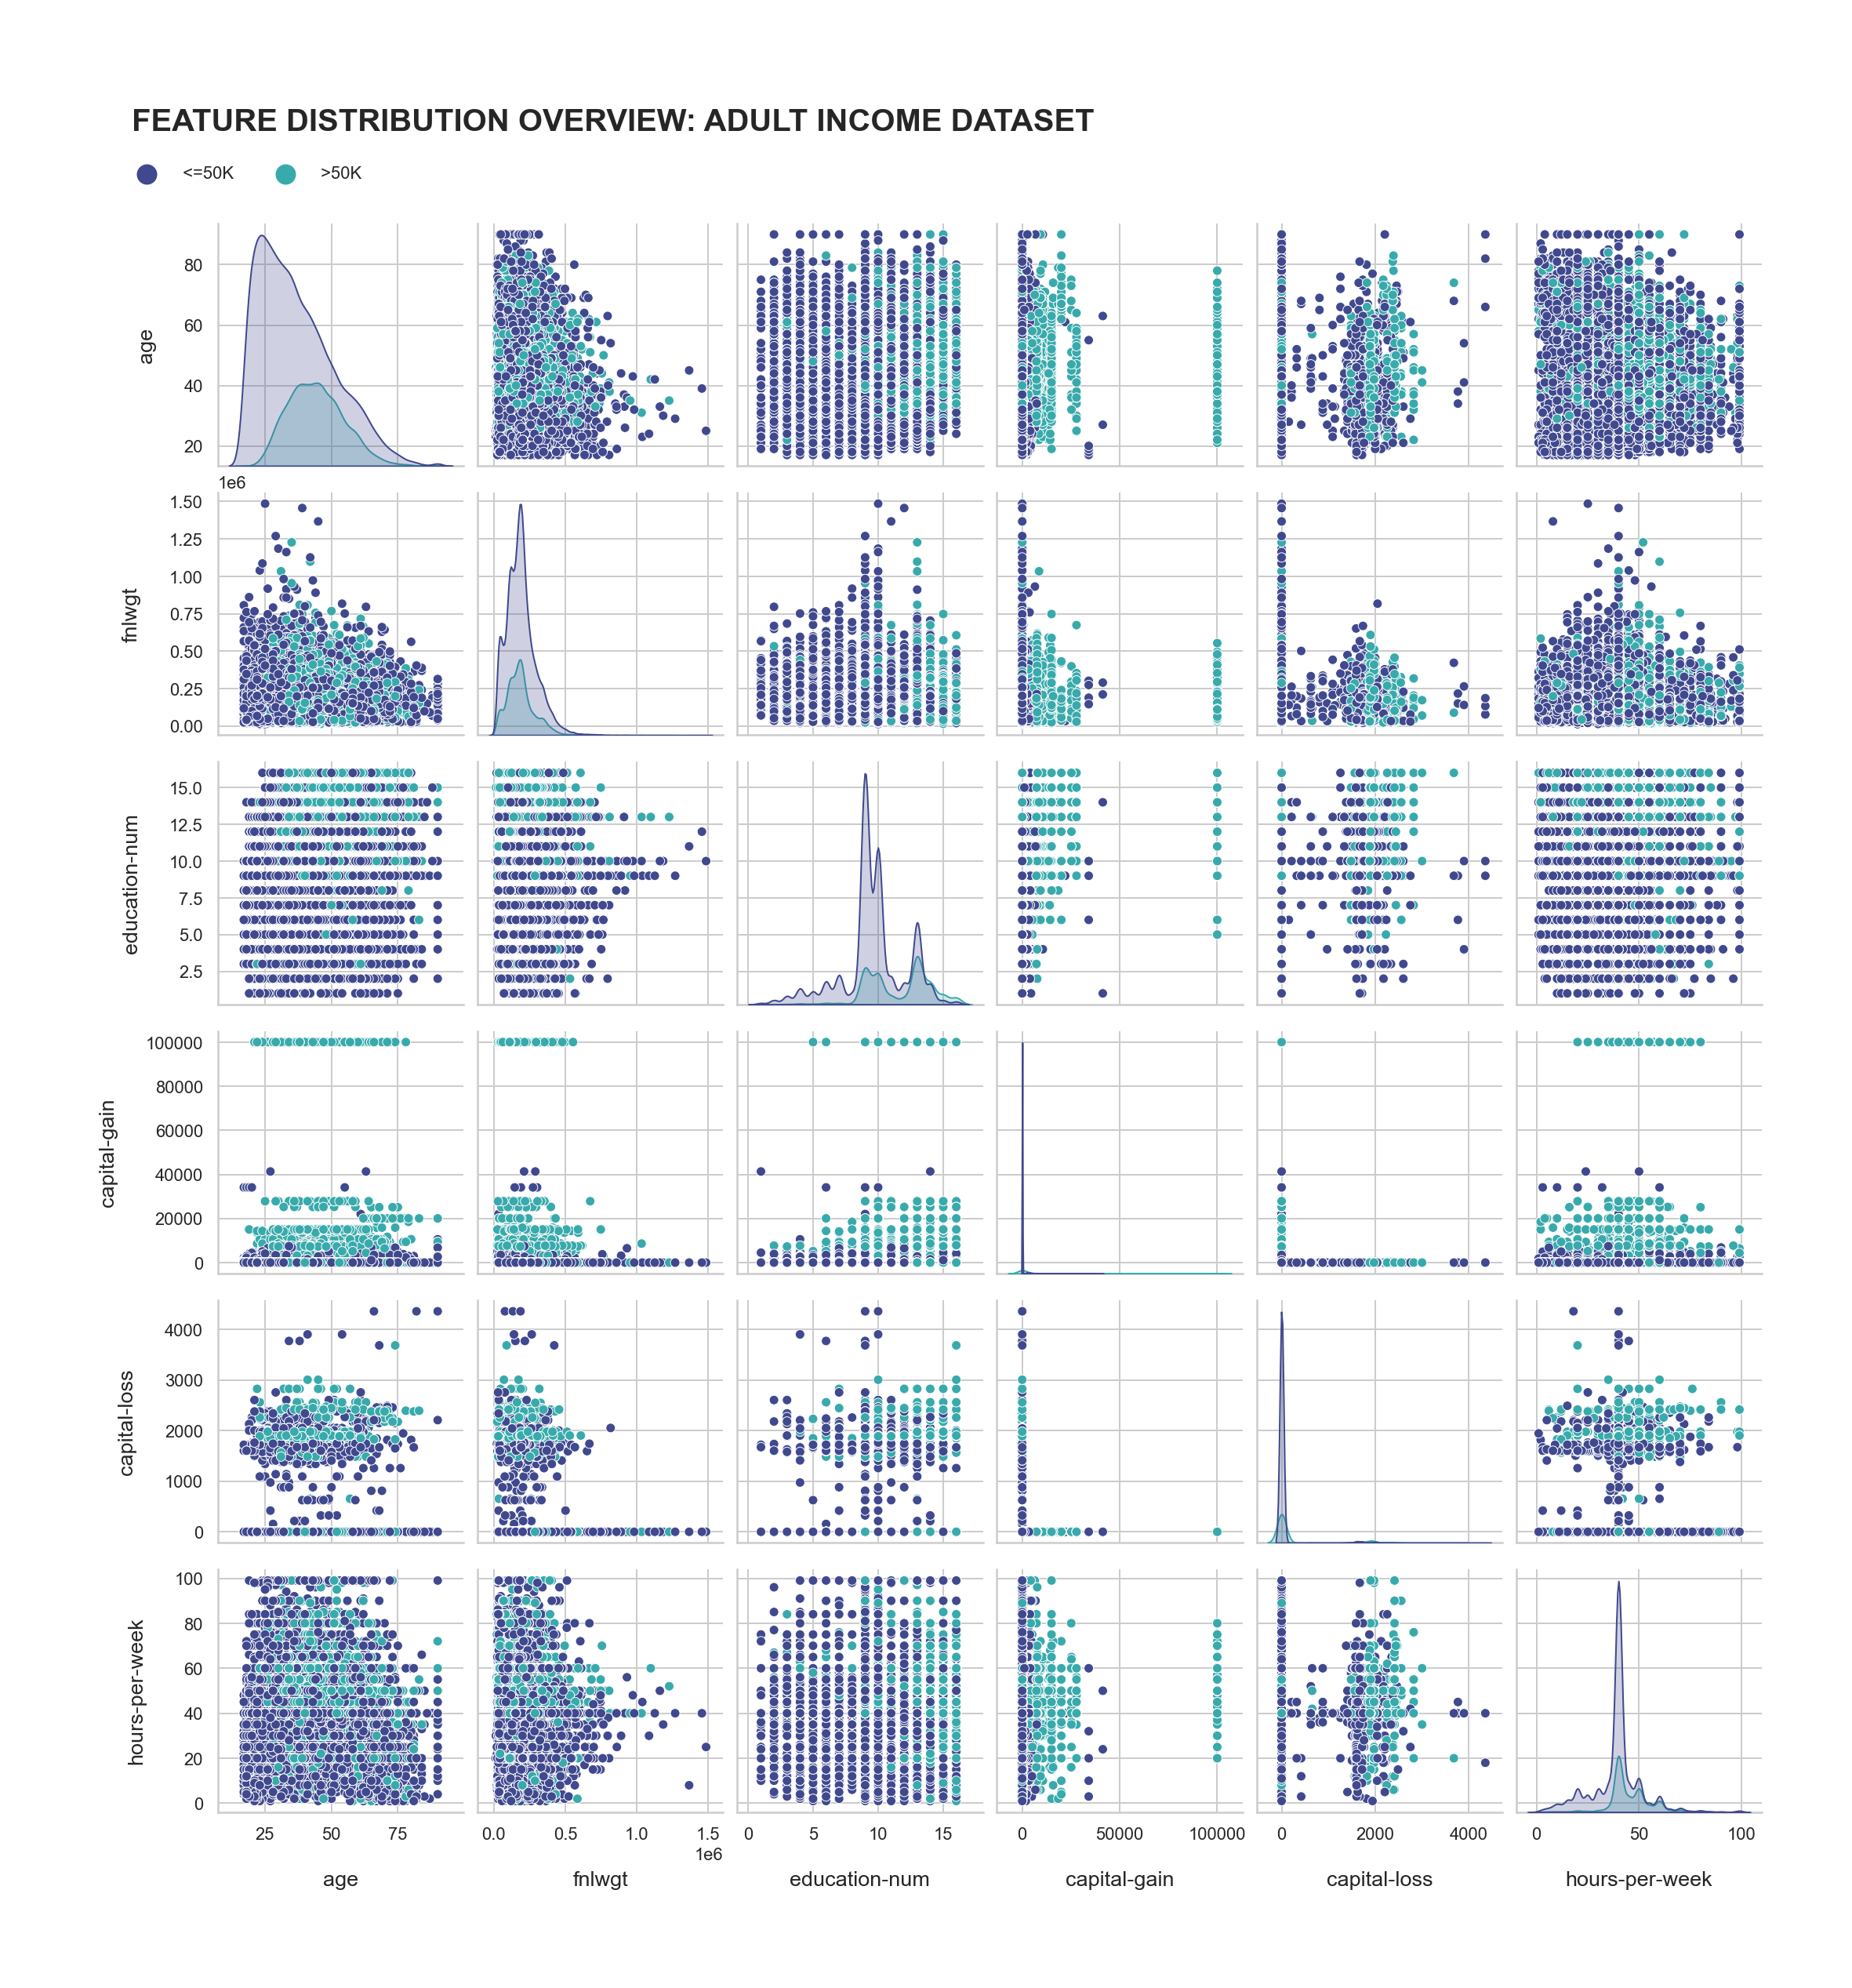

In [52]:
plot_pairplot(
    data = df_adult_income, hue = 'income', 
    vars = columns_df_adult_income_numerical,
    title = 'Feature distribution overview: Adult income dataset'
);

#### Points from the plot
* Age shows that the younger you are, the more likely you will earn more than 50K with mode near age 35 and people earning less than 50K at age near 25.
* Education-num indicates high kurtosis for all of its peaks; which could mean that the distribution of high income earners varies around the values 8 and 18.

### Feature correlation overview

In [53]:
def plot_heatmap(
    data, figsize: tuple = (18, 4), linewidths: int = 1,
    cmap = sns.color_palette(palette = palette_a2, as_cmap = True),
    title: str = None
) -> sns.heatmap:

    title = ' ' if title is None else title

    sns.set(style = 'whitegrid', rc = {'figure.figsize': figsize})

    g = sns.heatmap(
        data = data, linewidths = linewidths, 
        cmap = cmap, cbar_kws = dict(location = 'right'), 
        annot = True, fmt = ".3f", )

    g.set_xlabel(
        xlabel = "".join([(' '), ('\n'*1), (' '), ('\n'*2)]),
        fontdict = dict(fontsize = 13.5, fontweight = 'medium'), )

    g.set_ylabel(
        ylabel = "".join([(' '), ('\n'*2), (' '), ('\n'*1)]),
        fontdict = dict(fontsize = 13.5, fontweight = 'medium'), )    

    g.set_title(
        label = "".join([(' '), ('\n'*3), (title), ('\n')*1]).upper(),
        fontdict = dict(fontsize = 14, fontweight = 'bold'), loc = 'left')

    plt.text(
        s = ' ', x = 1.15, y = 1,
        transform = g.axes.transAxes)

    return g

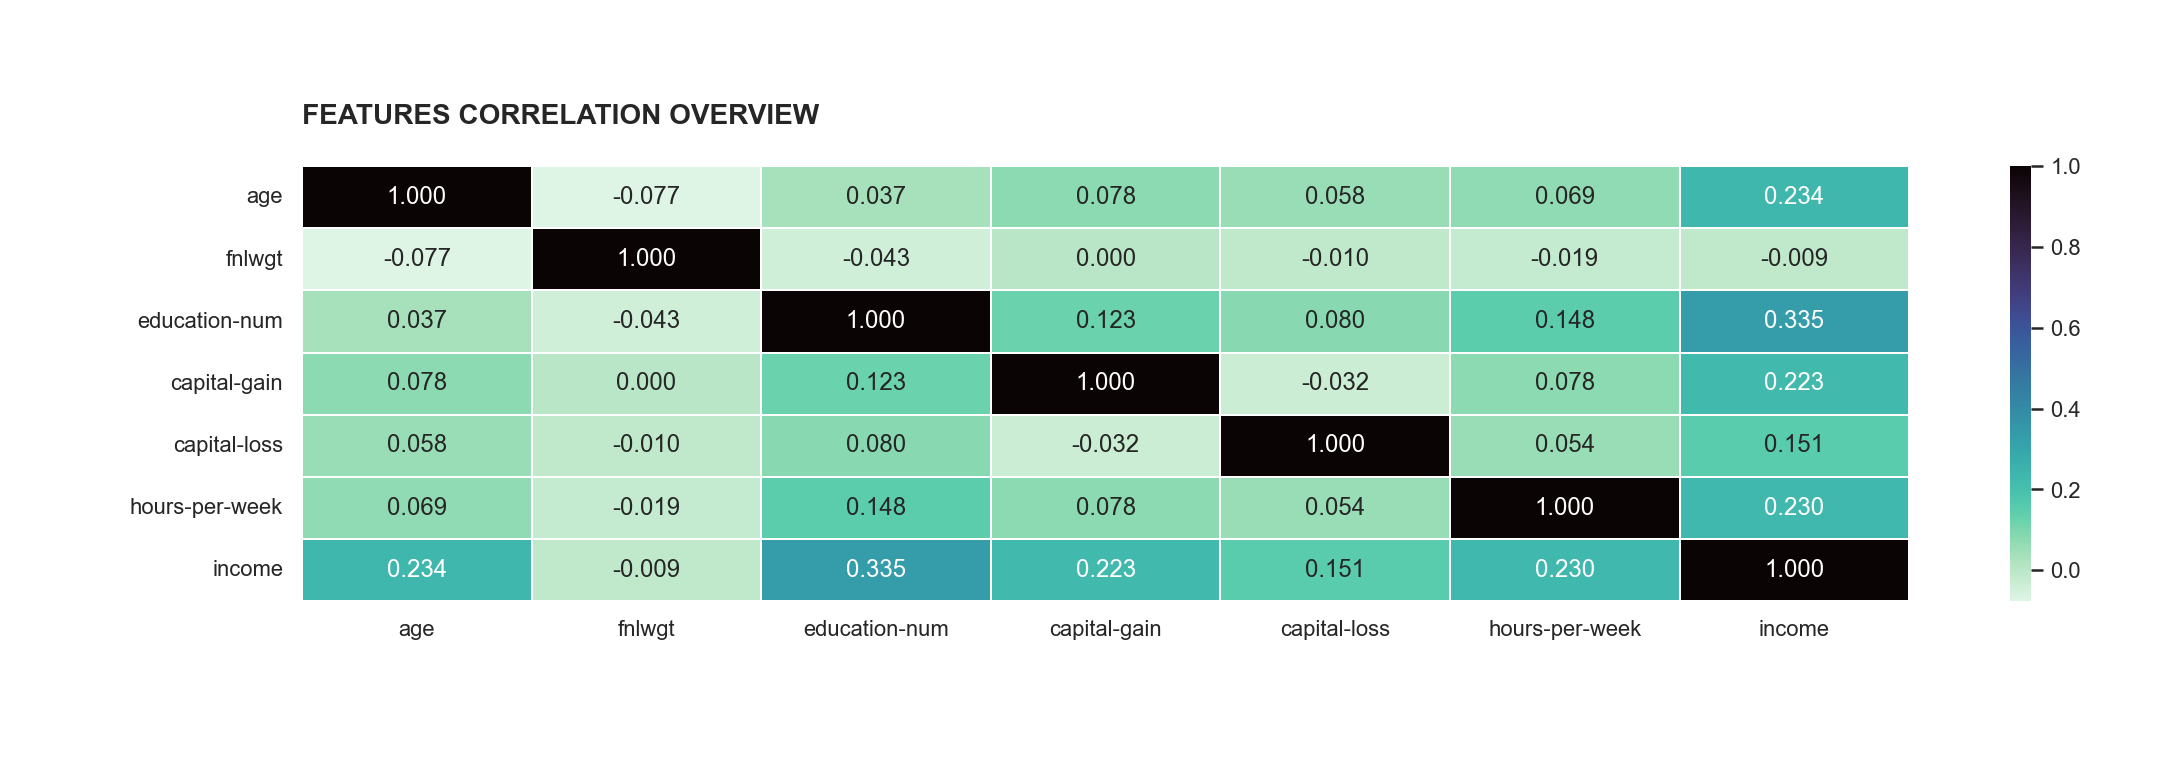

In [54]:
plot_heatmap(
    data = (
        df_adult_income
        .iloc[:, :-1]
        .join(
            df_adult_income['income']
            .map(encoded_target_values)
            .astype('float64'))
        .corr()),
        
    title = 'Features correlation overview'
);

With the numerical features, `education-num` seems to be most prominent out of the other numerical features in explaining the target class outcome with its `value of correlation of 0.335` compared to the other features which got a correlation value of 0.234 and below

### Count plot: categorical features as opposed to income

In [55]:
native_countries_with_high_respondents_base = ([
    country for country in (
        df_adult_income['native-country']
        .value_counts()
        .nlargest(10)
        .keys())])

print(native_countries_with_high_respondents_base)

[' United-States', ' Mexico', ' ?', ' Philippines', ' Germany', ' Canada', ' Puerto-Rico', ' El-Salvador', ' India', ' Cuba']


In [56]:
def plot_expanded_countplot(
    melted_dataframe, row: str, hue: str, x: str = None, 
    y: str = None, palette = None, title: str = None, aspect: int = 4
) -> sns.FacetGrid:

    palette = palette_a1 if palette is None else palette
    title = ' ' if title is None else title

    sns.set(style = 'whitegrid')

    g = sns.FacetGrid(
        data = melted_dataframe, row = row, hue = hue, 
        sharex = False, sharey = False, aspect = aspect, 
        palette = palette, )

    g.map_dataframe(func = sns.countplot, y = y, x = x)
    g.set_titles(template = '{row_name}')
    g.add_legend()

    for axis in g.axes:
        axis[0].set_title(
            label = axis[0].get_title().title(), loc = 'left', 
            fontdict = dict(fontweight = 'medium'))

        axis[0].set_xlabel(xlabel = "".join([(' ')]))
        axis[0].set_ylabel(ylabel = "".join([(' '), ('\n'*4)]))
        axis[0].set_title(label = ' ', loc = 'center')

    g.fig.suptitle(
        "".join([(' '), ('\n'*3), (title), ('\n'*1)]).upper(),
        fontweight = 'bold', y = 1.81, x = 0, fontsize = 15, 
        horizontalalignment = 'left', transform = g.axes[0, 0].transAxes)

    g.axes[len(g.axes)-1, 0].set_xlabel(
        xlabel = "".join([(' '), ('\n'*4)]), )

    plt.text(
        s = ' ', x = 1.1, y = 1,
        transform = g.axes[0,0].transAxes)

    sns.move_legend(
        obj = g, loc = 'lower center', bbox_to_anchor=(0.205, 1), 
        ncol=3, title=None, frameon=False,)

    plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

    sns.despine()

    return g

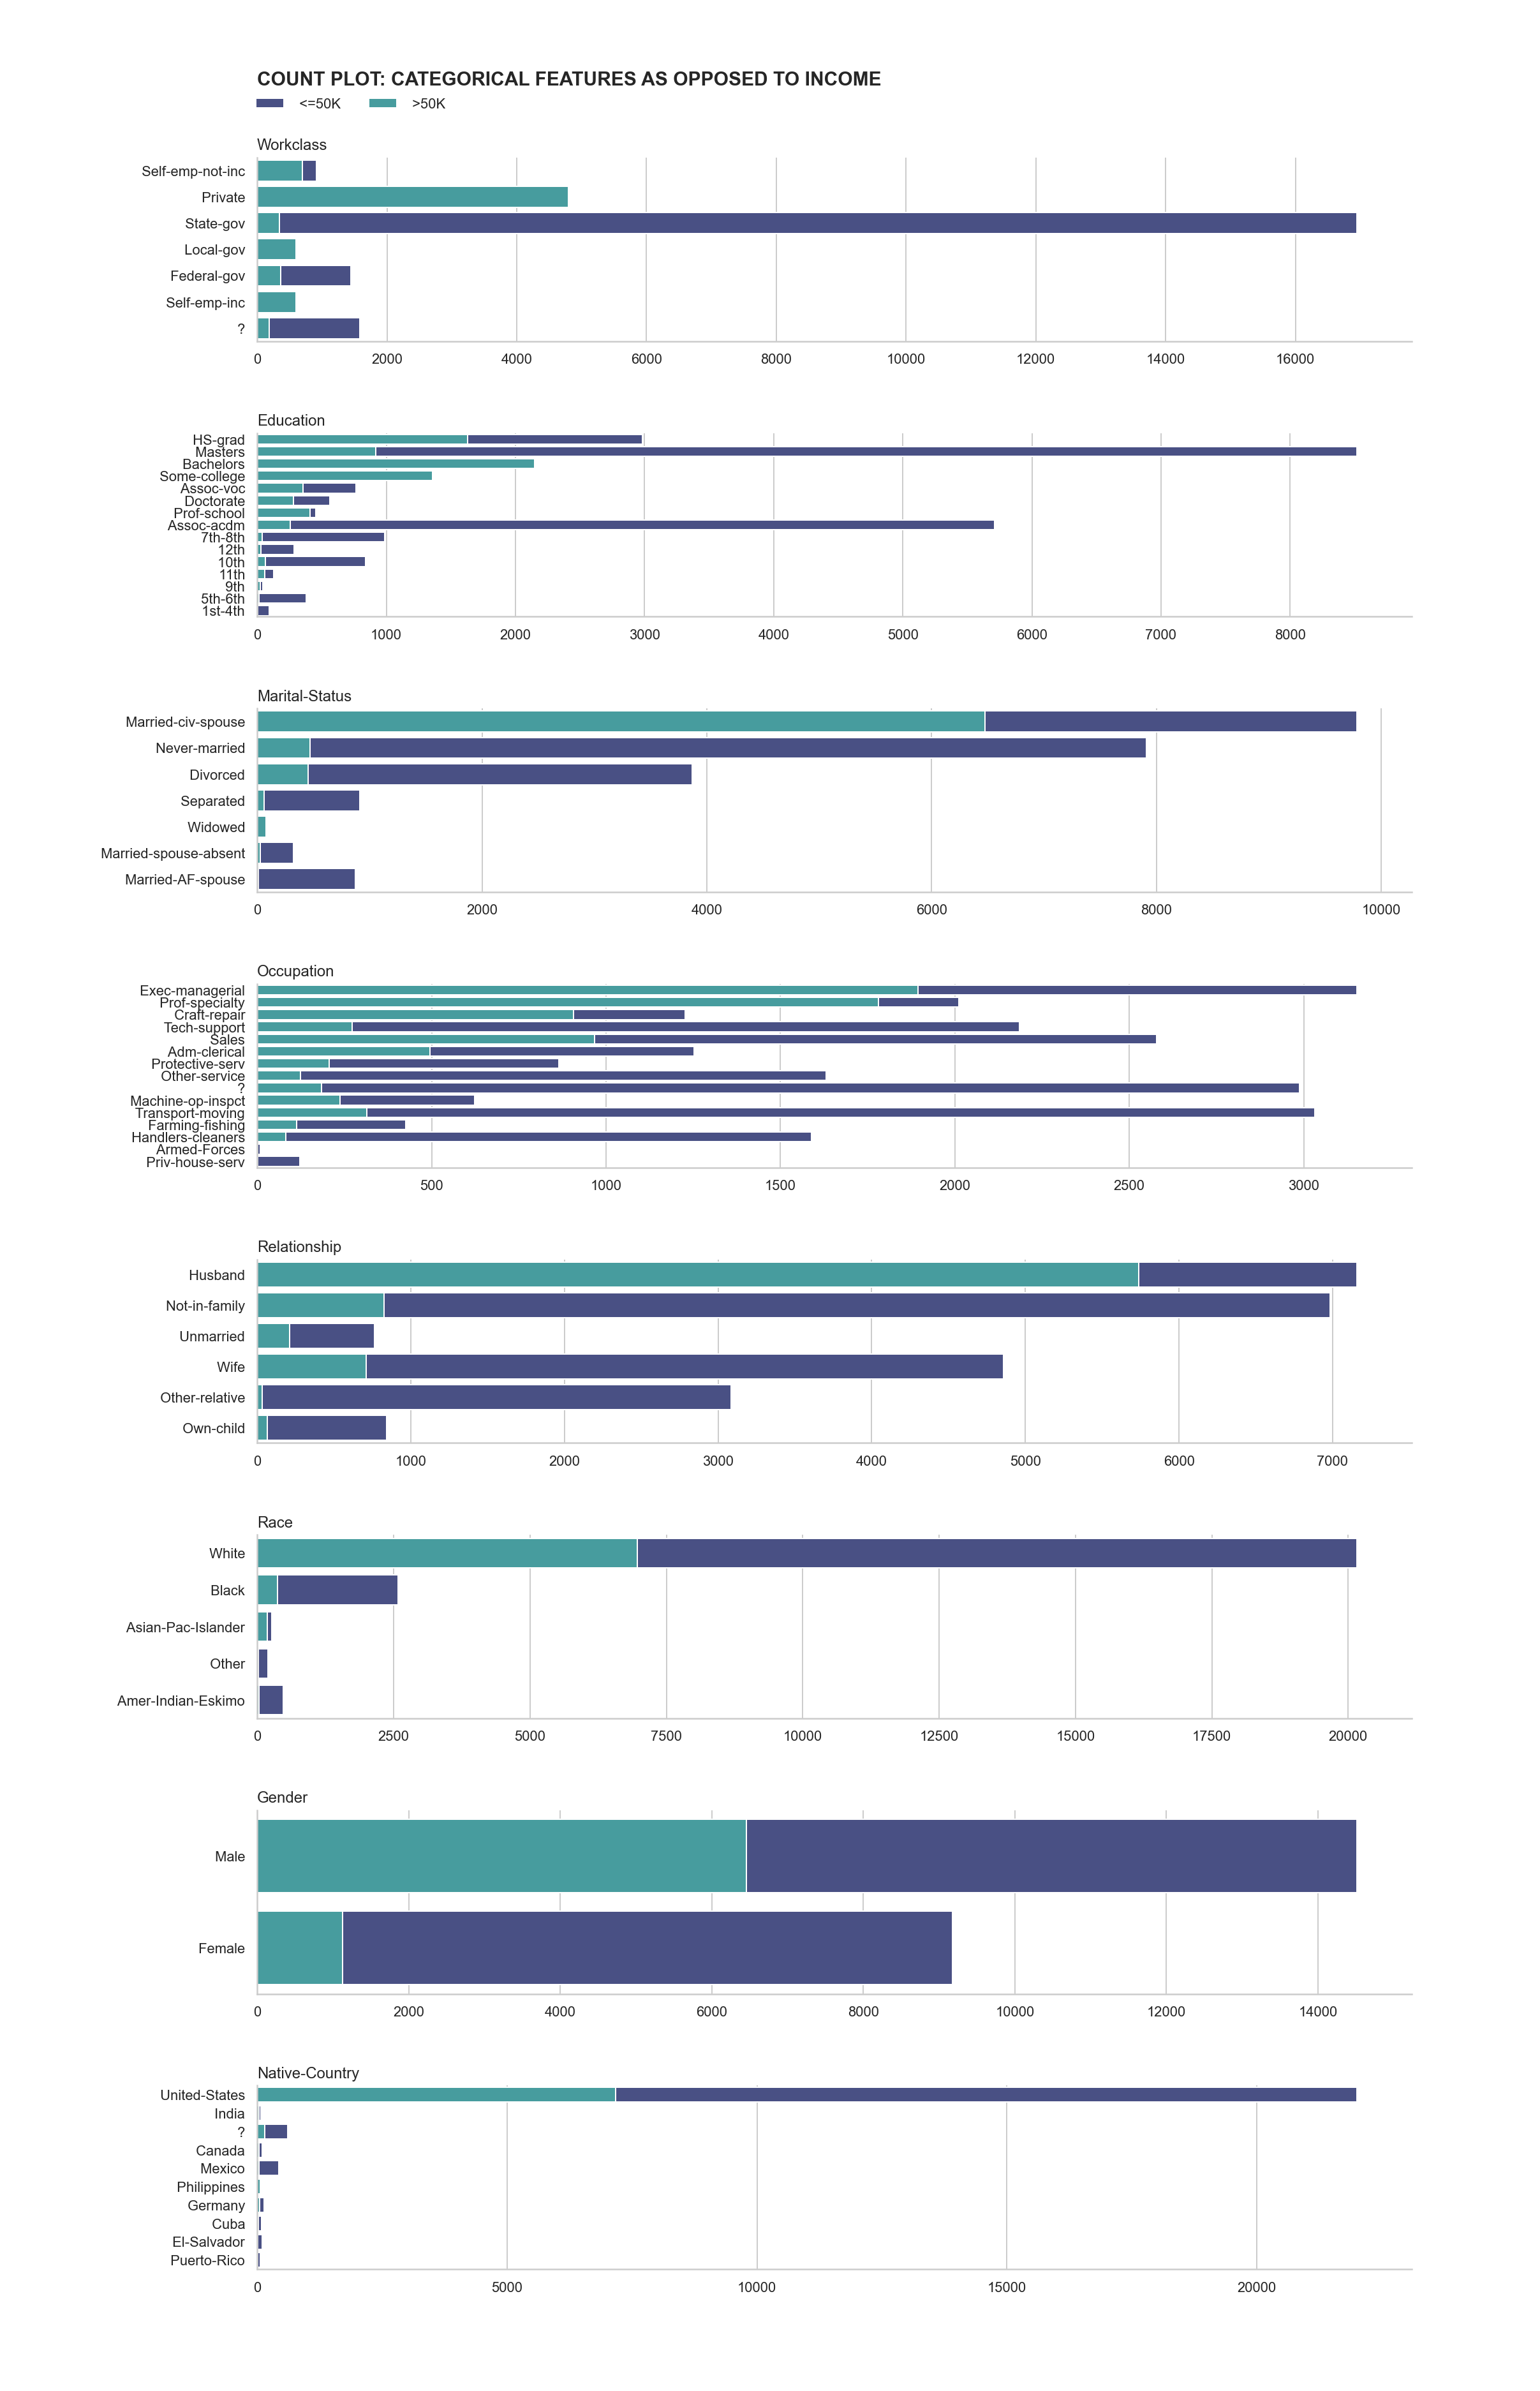

In [57]:
plot_expanded_countplot(
    melted_dataframe = (
        pd.melt(
            frame = (df_adult_income[df_adult_income['native-country'].isin(native_countries_with_high_respondents_base)]),
            id_vars = ['income'], value_vars = columns_df_adult_income_categorical, value_name = 'element')), 
    row = 'variable', hue = 'income', y = 'element', aspect = 5,
    title = "Count plot: Categorical features as opposed to income"
)

### Saving to local

In [58]:
if not os.path.exists('data'):
    os.mkdir('data')

df_adult_income.to_csv('data/adult.csv')

## Recreating the Utilizing the Expert Knowledge with the Adult Income Dataset

### Defining functions for smooth chaining with pandas' pipe method

#### Dataframe preprocessing

Firstly, I will be defining various functions to process the dataframe for something that can be of use to sklearn. Furthermore, in this step, the `scaling and encoding` of the features is included.

Several python libraries offer one-hot encoding functionality. However, it is `pandas` and `sklearn` that is used by the majority.
In choosing between the two, if your data will be used on machine learning, sklearn's one-hot encoding functionality would be a more better choice than that of pandas' for several reasons.

With that, I will be using Sklearn's `OneHotEncoder` and Scale the numerical columns using `MinMaxScaler` with the use of `ColumnTransformer`

In [59]:
def dataframe_preprocess(dataframe: pd.DataFrame, target_colname: str = None) -> pd.DataFrame:
    # Assign the target columns as the last column if nothing is provided in the target_colname parameter
    target_colname = dataframe.columns[-1] if target_colname is None else target_colname

    # Get column names of numerical and categorical features
    columns_df_numerical = [column for column in dataframe._get_numeric_data().columns]
    columns_df_categorical = [column for column in dataframe.columns if column not in columns_df_adult_income_numerical]

    # Converting the numerical and categorical features into its proper datatype
    dataframe[columns_df_numerical] = dataframe[columns_df_numerical].astype('float64')
    dataframe[columns_df_categorical] = dataframe[columns_df_categorical].astype('category')

    # Scale the numerical features and encode the categorical features
    column_transformer = (
        ColumnTransformer([
            ('scale', MinMaxScaler(), columns_df_adult_income_numerical),
            ('encode', OneHotEncoder(sparse = False), columns_df_adult_income_categorical[:-1])])
        .fit(dataframe))

    # Make a dataframe out of the transformed values
    processed_dataframe = (
        pd.DataFrame(
            data = column_transformer.transform(dataframe),
            columns = list(map(lambda x: x.replace('scale__', '').replace('encode__', ''), column_transformer.get_feature_names_out())))
        .join(dataframe[target_colname]))

    return processed_dataframe

#### Model training function

Training the model and making a dataframe out of the result will be done in this step. What will be added are the confusion matrix values for later to be visualized.

In [60]:
def train_model(dataframe: pd.DataFrame, algorithm, target_colname: str = None) -> pd.DataFrame:
    # Assign the target columns as the last column if nothing is provided in the target_colname parameter
    target_colname = dataframe.columns[-1] if target_colname is None else target_colname

    # Assigning the primary variables from the dataframe
    var_X = dataframe.iloc[:, :-1]
    var_y = dataframe[target_colname]

    # Spliting to train and test variables
    var_X_train, var_X_test, var_y_train, var_y_test = train_test_split(
        var_X, var_y, stratify = var_y, random_state = 0)

    # Model training
    model = algorithm.fit(var_X_train, var_y_train)

    # Assign predicted y values
    var_y_train_pred = model.predict(var_X_train)
    var_y_test_pred = model.predict(var_X_test)

    # Method to extract the confusion matrix values from 2x2 array into 1 list
    def list_confusion_matrix_values(conf_matrix: np.array) -> list:
        return [y for x in conf_matrix.reshape(1,-1) for y in x]

    # Make a new dataframe with the predicted values from the model
    processed_dataframe = pd.DataFrame(dict(
        element = ['True Negative', 'False Positive', 'False Negative', 'True Positive'] * 2,
        value = (
            list_confusion_matrix_values(confusion_matrix(y_true = var_y_train, y_pred = var_y_train_pred))
            + list_confusion_matrix_values(confusion_matrix(y_true = var_y_test, y_pred = var_y_test_pred))),
        total = [len(var_y_train) for x in range(4)] + [len(var_y_test) for x in range(4)],
        set = ('Train '*4).split() + ('Test '*4).split(), ))
    
    # Evaluate train and test
    train_score = model.score(X = var_X_train, y = var_y_train)
    test_score = model.score(X = var_X_test, y = var_y_test)

    # Summarize classification results
    classification_result_report_train = classification_report(y_true = var_y_train, y_pred = var_y_train_pred)
    classification_result_report_test = classification_report(y_true = var_y_test, y_pred = var_y_test_pred)


    return processed_dataframe, train_score, test_score, classification_result_report_train, classification_result_report_test

#### Visualizing model evaluation

In [61]:
def visualize_model_evaluation(
    dataframe: pd.DataFrame, train_score: np.float64, test_score:np.float64, 
    classification_report_train: str, classification_report_test: str,
    palette = None, height: int = 3, aspect: int = 4, sharex: bool = False,
    subtitle_model: str = None,
) -> sns.FacetGrid:

    palette = palette_a1 if palette is None else palette
    subtitle_model = ' ' if subtitle_model is None else subtitle_model

    sns.set(style = 'whitegrid')

    g = sns.FacetGrid(
        data = dataframe, row = 'set', height = height, 
        aspect = aspect, sharex = sharex, )

    g.map_dataframe(
        func = sns.barplot, x = 'value', y = 'element', 
        palette = palette)

    g.fig.suptitle(
        "".join([(' '), ('\n'*3), ('Model evaluation on Adult Income Dataset'), ('\n'*1)]).upper(),
        fontweight = 'bold', y = 1.6, horizontalalignment = 'left', x = 0, transform = g.axes[0,0].transAxes)

    plt.text(
        s = "".join([('Model: '),(subtitle_model)]), x = 0, y = 1.05,
        alpha = 0.5, transform = g.axes[0,0].transAxes)

    plt.text(
        s = classification_report_train.upper(), x = 1.1, y = 0,
        alpha = 0.8, transform = g.axes[0,0].transAxes,
        fontdict = dict(fontfamily = 'monospace'))

    plt.text(
        s = classification_report_test.upper(), x = 1.1, y = 0,
        alpha = 0.8, transform = g.axes[1,0].transAxes,
        fontdict = dict(fontfamily = 'monospace'))        

    g.set_titles(row_template = '{row_name} Set',)
        
    for axes in g.axes:
        for axis in axes:
            axis.bar_label(axis.containers[0], padding = 10)
            axis.set_ylabel("".join([(' '), ('\n'*3)]))
            axis.set_xlabel(
                xlabel = (
                    "".join([(' '), ('\n'*1), (axis.get_title()), (': '), 
                    ('Accuracy Score = '), (f'{train_score: .3f}' if axis == g.axes[0,0] else f'{test_score: .3f}'), 
                    ('\n'*3)])),
                fontdict = dict(fontsize = 13, fontweight = 'medium'), 
                loc = 'left')
            axis.set_title(' ')

    plt.text(
        s = ' ', x = 1.7, y = 1,
        transform = g.axes[0,0].transAxes)

    plt.subplots_adjust(hspace = 0.5)

    sns.despine()

    return g

#### Compiled function for evaluation

In [62]:
def evaluate_model(dataframe: pd.DataFrame, model, model_name: str) -> None:
    dataframe, train_score, test_score, classification_report_train, classification_report_test = (
        dataframe
            .pipe(dataframe_preprocess)
            .pipe(train_model, algorithm = model))

    return (
        visualize_model_evaluation(
            dataframe, train_score, test_score,
            classification_report_train, classification_report_test,
            subtitle_model = model_name))

### Execution

#### Logistic regression

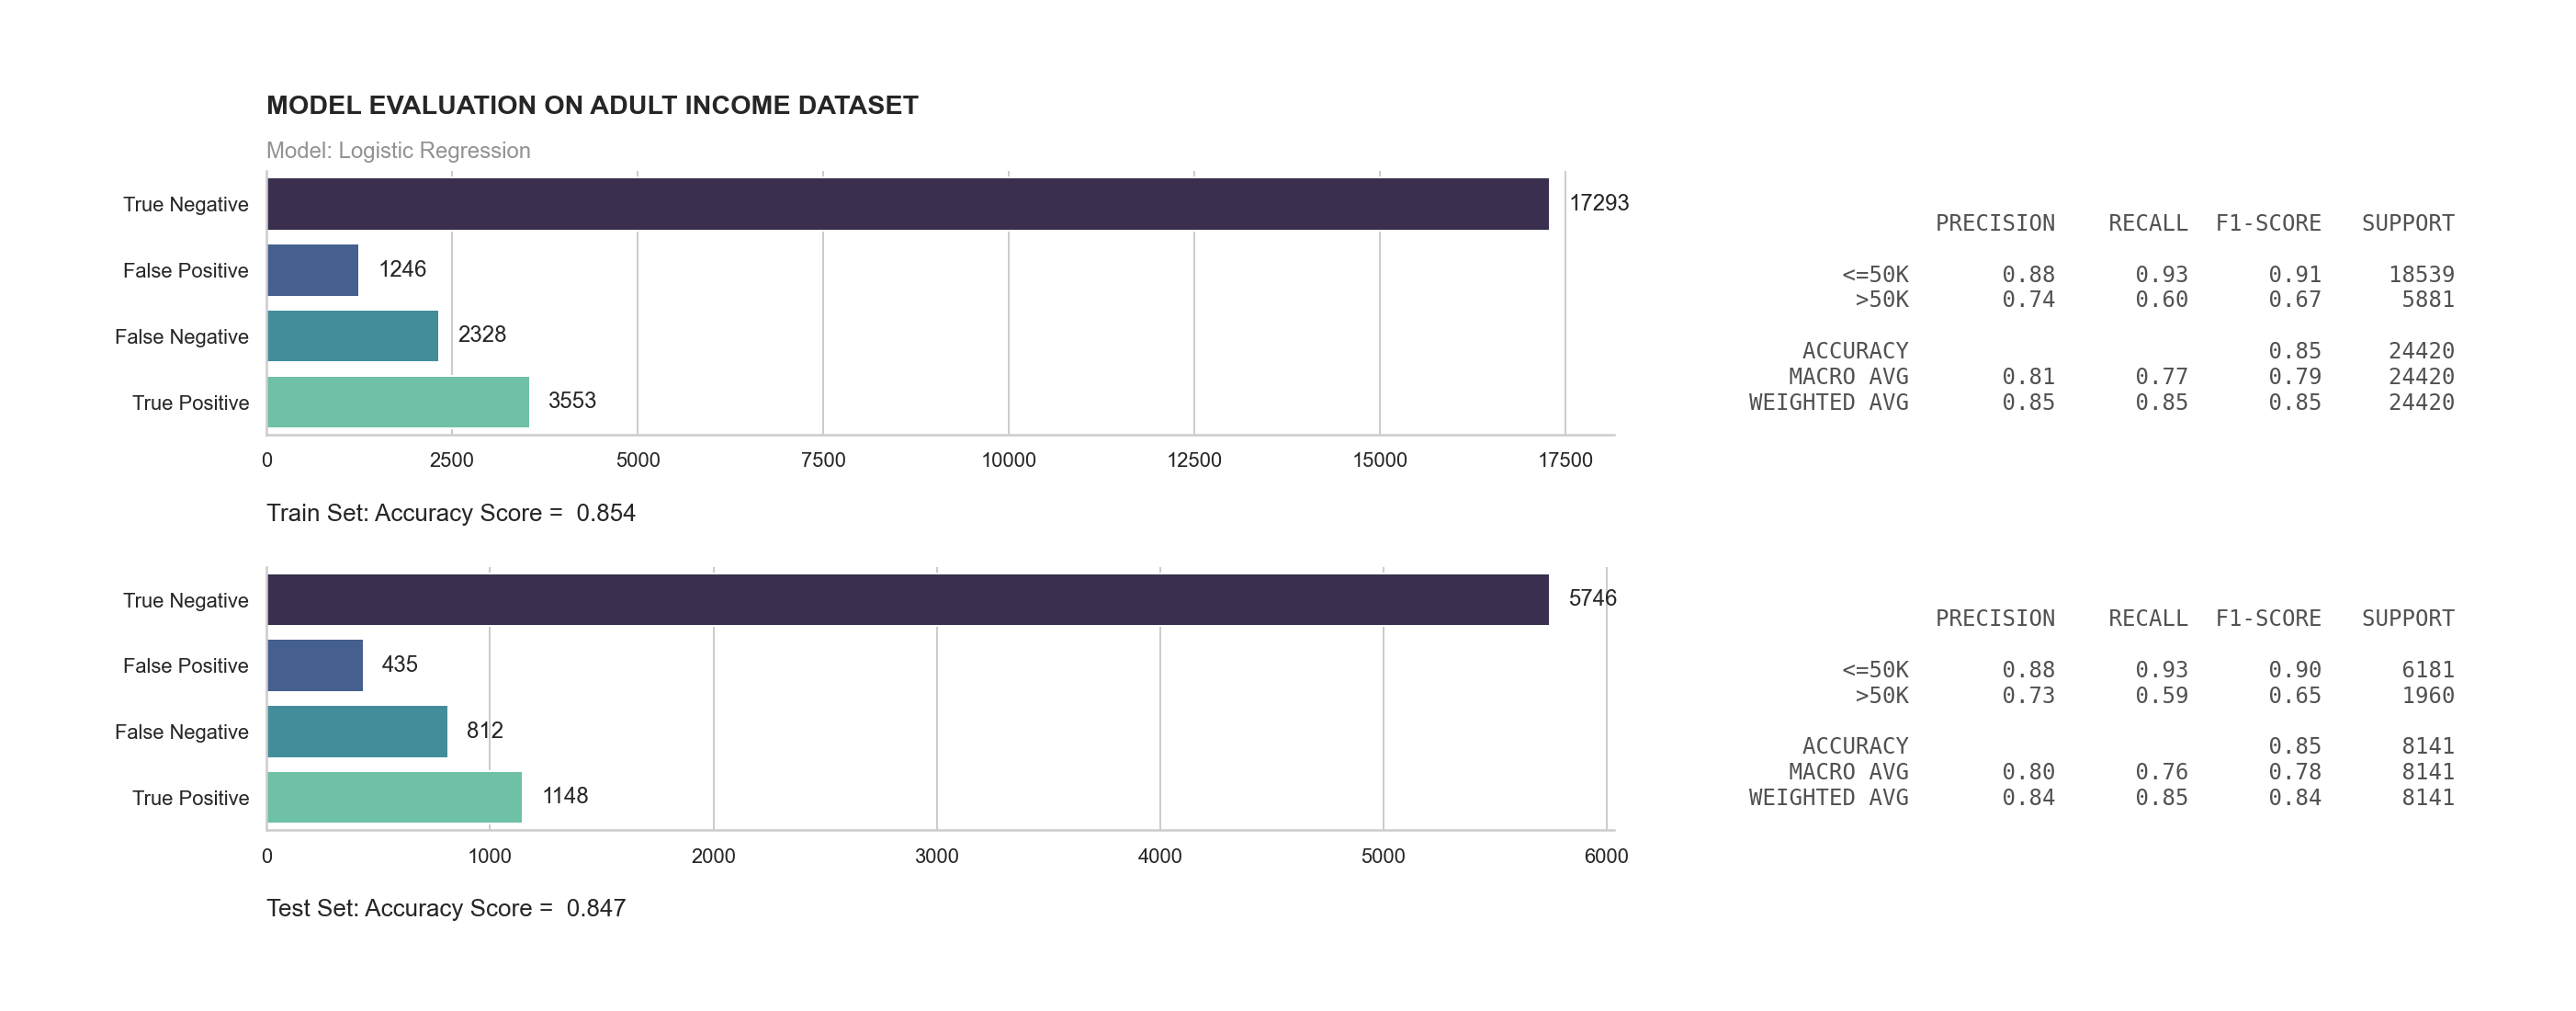

In [63]:
evaluate_model(
    dataframe = df_adult_income,
    model = LogisticRegression(C = 1, max_iter = 5000),
    model_name = 'Logistic Regression', )

#### Random Forest Classifier

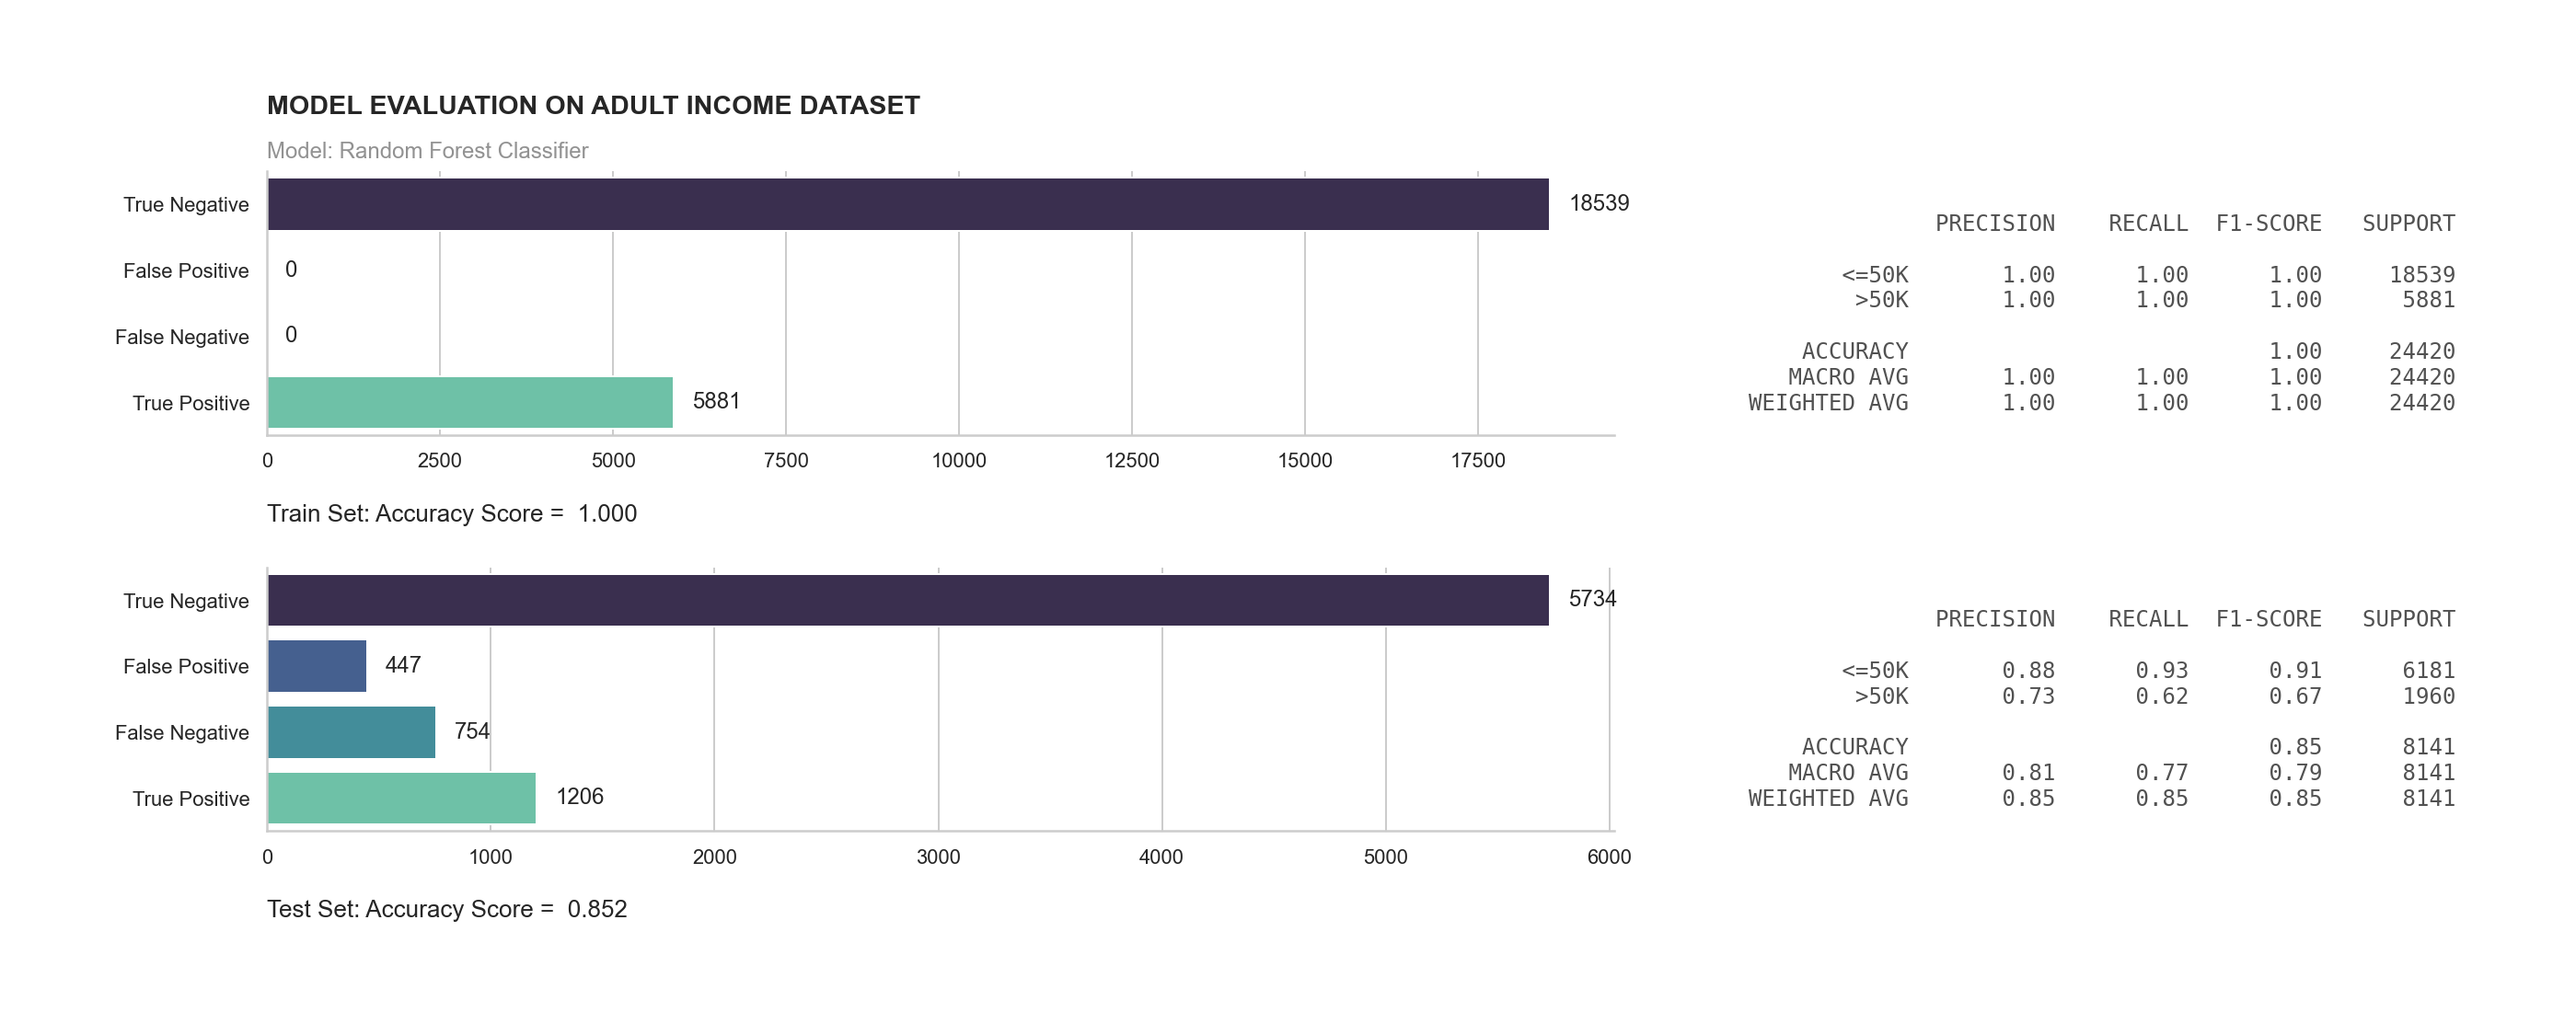

In [64]:
evaluate_model(
    dataframe = df_adult_income,
    model = RandomForestClassifier(random_state = 0, max_features = 'sqrt', n_estimators = 90),
    model_name = 'Random Forest Classifier', )

#### Support Vector Machine

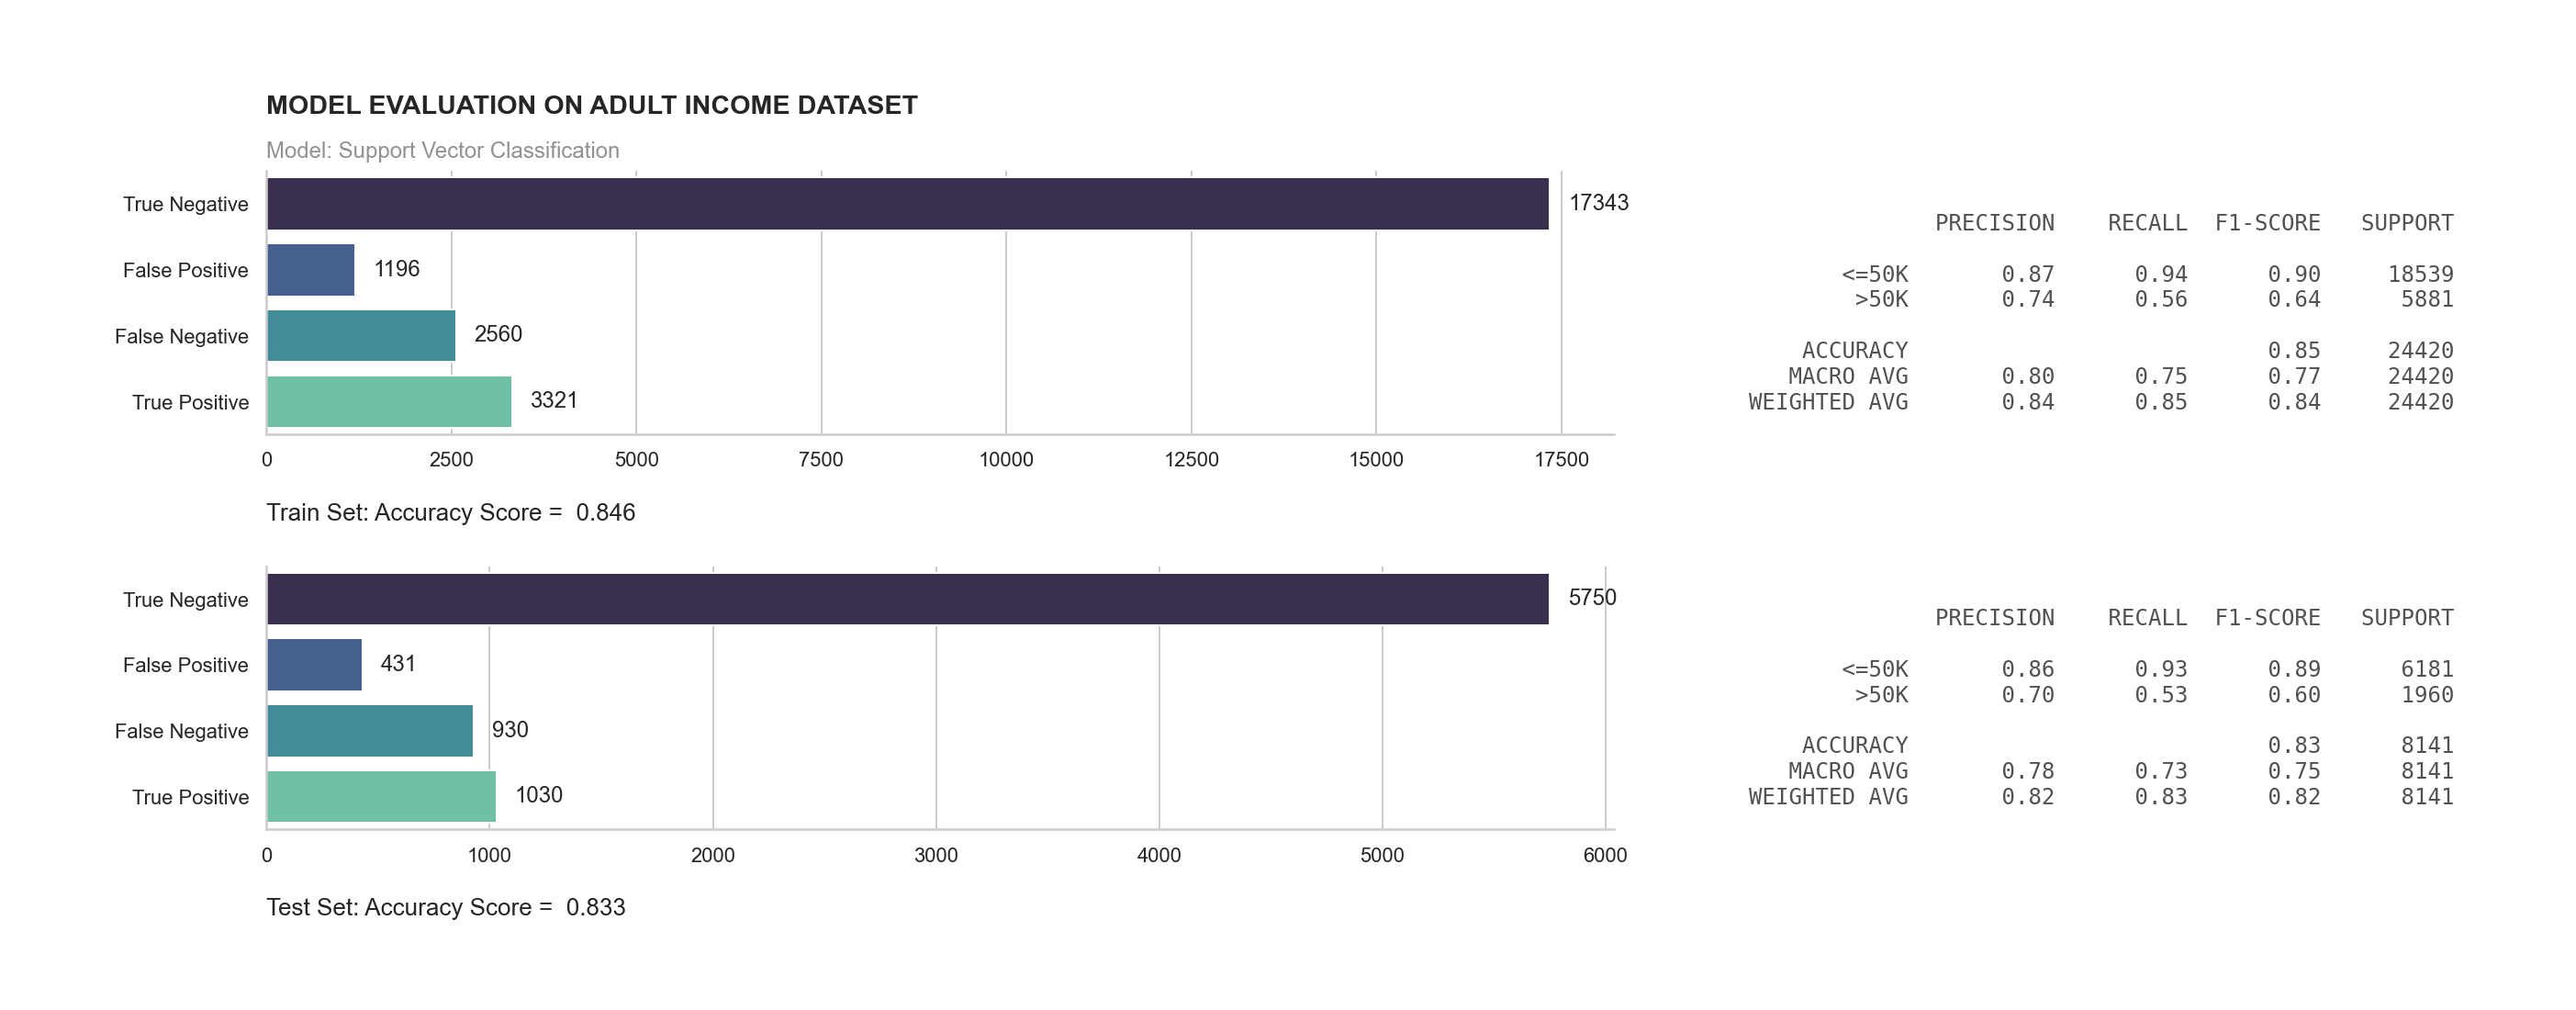

In [65]:
evaluate_model(
    dataframe = df_adult_income,
    model = SVC(C = 1),
    model_name = 'Support Vector Classification', )